In [1]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import json
import re
from datetime import datetime
import seaborn as sns
from nba_api.stats.endpoints import shotchartdetail
from nba_api.stats.static import players
from draw_court import draw_court
pd.set_option('display.max_columns', None)
plt.style.use('fivethirtyeight')

# Retreive data using nba_api
This is a [great, highly recommended package](https://pypi.org/project/nba-api/) for anyone interested in easily accessing raw NBA stats.

In [2]:
## Find ID for Giannis
giannis = players.find_players_by_first_name('giannis')
giannis[0]['id']

203507

Retrieve data for all of Giannis' career.

In [3]:
years = ['2013-14', '2014-15', '2015-16', '2016-17', '2017-18',
         '2018-19', '2019-20', '2020-21']
headers = None
all_shots = []

for year in years:
    response = shotchartdetail.ShotChartDetail(
        team_id=0,
        player_id=203507,
        season_nullable=year,
        season_type_all_star='Regular Season',
        context_measure_simple='FGA'
    )

    content = json.loads(response.get_json())
    if headers is None:
        headers = content['resultSets'][0]['headers']
        headers.append('YEAR')
    
    shots = content['resultSets'][0]['rowSet']
    for shot in shots:
        shot.append(year)
        all_shots.append(shot)

shots_df = pd.DataFrame(all_shots, columns=headers)

In [4]:
### write_data locally so I don't have to retrieve it each time
shots_df.to_csv(os.getcwd() + '/data/raw_giannis_data.csv', index=None)

In [5]:
### read local copy
shots_df = pd.read_csv(os.getcwd() + '/data/raw_giannis_data.csv')

### Create a simplified df with more user-friendly columns

In [6]:
shots = shots_df.copy(deep=True)

## simplify year fields
shots['YEAR'] = shots.YEAR.str.replace(r'\d+-',r'')

shots['home'] = np.where(shots.HTM=='MIL', 1, 0)

shots = shots.rename(columns={
                            'PERIOD': 'qtr',
                            'MINUTES_REMAINING': 'minutes',
                            'SECONDS_REMAINING': 'seconds',
                            'ACTION_TYPE': 'shot_type',
                            'SHOT_ZONE_BASIC': 'zone',
                            'SHOT_ZONE_AREA': 'direction',
                            'SHOT_ZONE_RANGE': 'range',
                            'SHOT_DISTANCE': 'distance',
                            'SHOT_MADE_FLAG': 'made',
                            'LOC_X': 'X',
                            'LOC_Y': 'Y',
                            'SHOT_TYPE': '2pt_3pt',
                            })

In [7]:
### isolate opponent to one column
shots['opponent'] = np.where(shots.HTM=='MIL', shots.VTM, shots.HTM)

### consolidate time fields at the minute level
shots['time_left'] = shots.minutes * 60 + shots.seconds

### create a time left in game field
shots['game_time_left'] = np.where(shots.qtr==5, -5 + shots.minutes,
                            48 - shots.qtr * 12 + shots.minutes)

### create a binary 3pt field
shots['pt3'] = np.where(shots['2pt_3pt'].str.contains('3'), 1, 0)

### create attempted col
shots['attempted'] = 1

## Since he started shooting more threes in recent years, we'll use EFG%
## instead of FG% when eventually calculating accuracy
shots['made_efg'] = np.where((shots.made==1) & (shots.pt3==1),
                            1.5, shots.made) 

In [8]:
### drop unneeded columns
shots.drop(['GRID_TYPE', 'GAME_ID', 'GAME_EVENT_ID', 'PLAYER_ID', 'TEAM_ID',
            'PLAYER_NAME', 'EVENT_TYPE', 'TEAM_NAME', 'SHOT_ATTEMPTED_FLAG',
            '2pt_3pt', 'HTM', 'VTM'], axis=1, inplace=True)

**I'm interested in how Giannis' shooting accuracy, shot selection and shot volume have changed over time, so I'm going to slice up his data in a variety of ways:**
- By specific location of the court (area of greatest interest)
- By quarter
- By shot type (layup, fadeaway, etc.)
- By zone of the court
- By distance
- By direction of the court (right, left, center, etc

# Visualize shot distriubtion

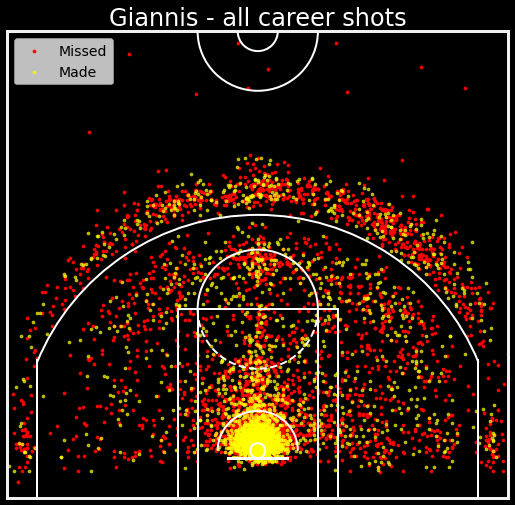

In [9]:
### The draw_court() function used here came from:
    ## http://savvastjortjoglou.com/nba-shot-sharts.html

makes = shots[shots.made==1]
misses = shots[shots.made==0]
fig, ax = plt.subplots(figsize=(8,8))
fig.patch.set_facecolor('black')
ax.scatter(misses.X, misses.Y, c='red', s=10, label='Missed')
ax.scatter(makes.X, makes.Y, c='yellow', s=10, label='Made', alpha=0.7)
ax.patch.set_facecolor('black')
draw_court(color='white')
plt.xlim(250, -250)
plt.ylim(-47.5, 422.5)
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)
ax.legend()
ax.set_title('Giannis - all career shots', size=24, color='white')
plt.show()

## Visualize shot efficiency using hexbins

In [10]:
def bin_shots(df, binthresh=5, gridsize=30):
    '''
    Takes in a df with x/y columns for shot locations, a threshold for
    the number of shots needed in a bin before it should be included,
    and the number of bins to be included across the width of the grid.
    Returns coordinates of bins and numeric values (FG %) for each bin.
    '''
    shots_hex = plt.hexbin(
        df.X, df.Y,
        extent=(-250, 250, 422.5, -47.5), gridsize=gridsize)

    makes = df[df.made == 1]
    makes_hex = plt.hexbin(
        makes['X'], makes['Y'],
        extent=(-250, 250, 422.5, -47.5), gridsize=gridsize)
    plt.close()
    pcts_by_hex = makes_hex.get_array() / shots_hex.get_array()

    sample_sizes = shots_hex.get_array()

    for i in range(len(pcts_by_hex)):
        ### only include a bin if the number of shots meets a threshold
        if sample_sizes[i] < binthresh:
            pcts_by_hex[i] = np.nan
    x = [i[0] for i in shots_hex.get_offsets()]
    y = [i[1] for i in shots_hex.get_offsets()]
    return x, y, pcts_by_hex

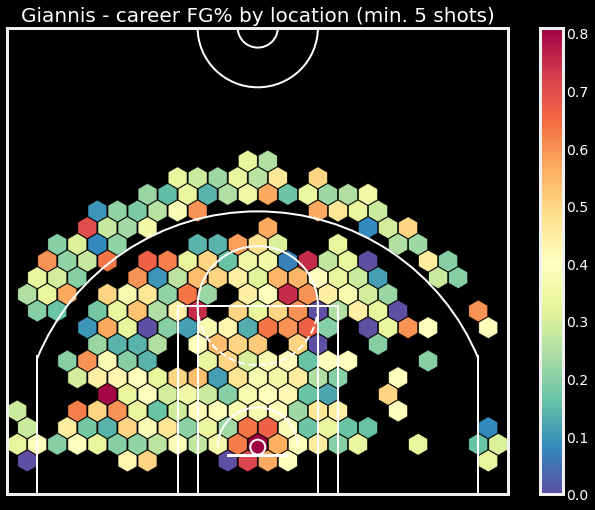

In [13]:
np.seterr(divide='ignore', invalid='ignore')
x, y, pcts_by_hex = bin_shots(df=shots, binthresh=5, gridsize=25)

fig, ax = plt.subplots(figsize=(10, 8))
fig.patch.set_facecolor('black')

plt.scatter(x, y, c=pcts_by_hex, cmap='Spectral_r',
            marker='h', s = 475, edgecolor='black')

color_bar = plt.colorbar()
cbytick = plt.getp(color_bar.ax.axes, 'yticklabels')
plt.setp(cbytick, color='white')
draw_court(color='white')
plt.xlim(-250, 250)
plt.ylim(-47.5, 422.5)
ax.patch.set_facecolor('black')
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)
ax.set_title('Giannis - career FG% by location (min. 5 shots)',
             size=20, color='white')
plt.show()

## How has shot selection changed over time?

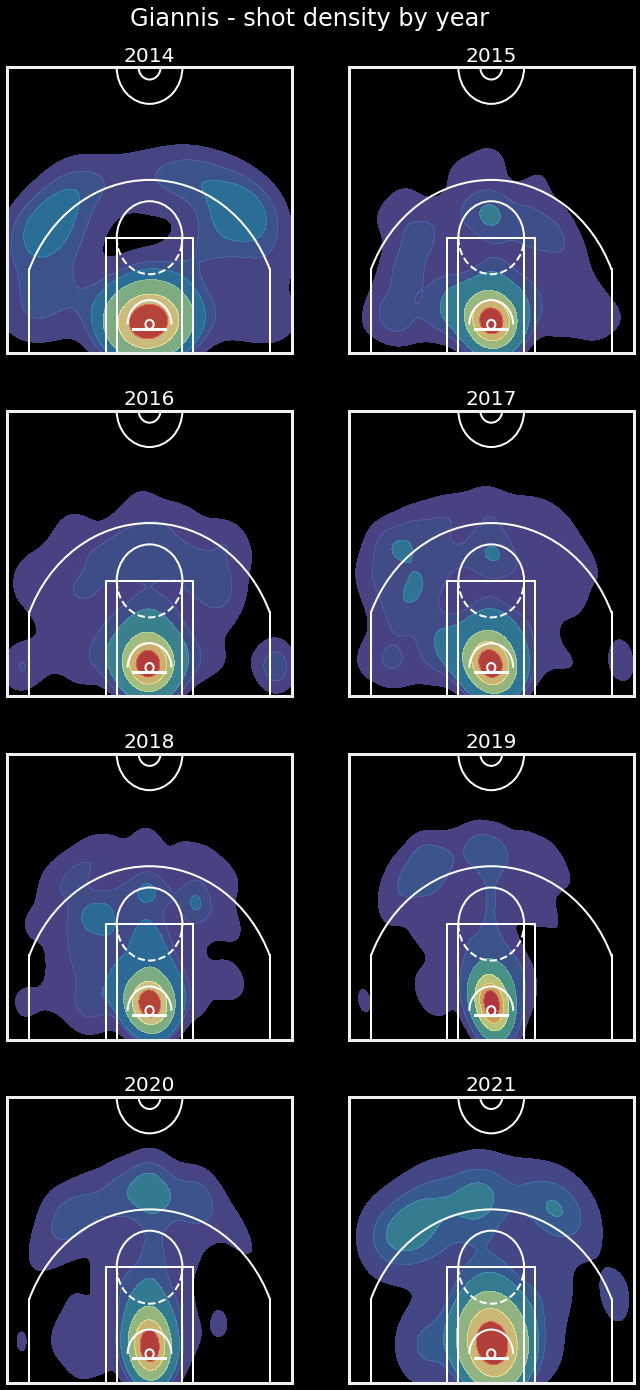

In [18]:
years = ['14', '15', '16', '17', '18', '19', '20', '21']
fig = plt.figure(figsize=(10, 21))
fig.patch.set_facecolor('black')
for i in range(1, len(years)+1):
    year = years[i-1]
    plt.subplot(4,2,i)
    plt.xlim(-260, 260)
    plt.ylim(-47.5, 422.5)
    ax = sns.kdeplot(data=shots[shots.YEAR==year], x="X", y="Y",
            cmap='Spectral_r', thresh=0.05, fill=True, levels=7, alpha=0.8)
    ax.patch.set_facecolor('black')
    draw_court(color='white')
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    ax.set_title('20' + year, color='white')
plt.suptitle('Giannis - shot density by year', color='white', size=24)
plt.subplots_adjust(top=0.94)
plt.show()

In his rookie year, Giannis had a pretty varied shot selection, including shooting a decent number of threes.  It's pretty obvious that he was told to stop shooting threes over the next couple years, during which he had a lot more 15-20 ft. mid-range shots, mostly from straight on or from the left side. The threes start to pick up a bit in 2017, and then, when Budenholzer arrive as the coach in 2019, the midrange shots drop off significantly, the threes return, and the share of shots clustered around the basket rises. At this point, most of his jumpers (excluding threes) are from the lower block, which --- if you watch them on TV -- it's pretty clear he's making a concerted effort to develop more of a post game.

## How has shooting efficiency changed over time?

In [21]:
years = ['14', '15', '16', '17', '18', '19', '20', '21']
### build up a dict of hexbins and x/y coords for each year
year_dict = {}
for year in years:
    year_dict[year] = {'X': None, 'Y': None, 'pcts_by_hex': None}
    x, y, pcts_by_hex = bin_shots(df=shots[shots.YEAR==year],
                    binthresh=3, gridsize=20)
    year_dict[year]['X'] = x
    year_dict[year]['Y'] = y
    year_dict[year]['pcts_by_hex'] = pcts_by_hex

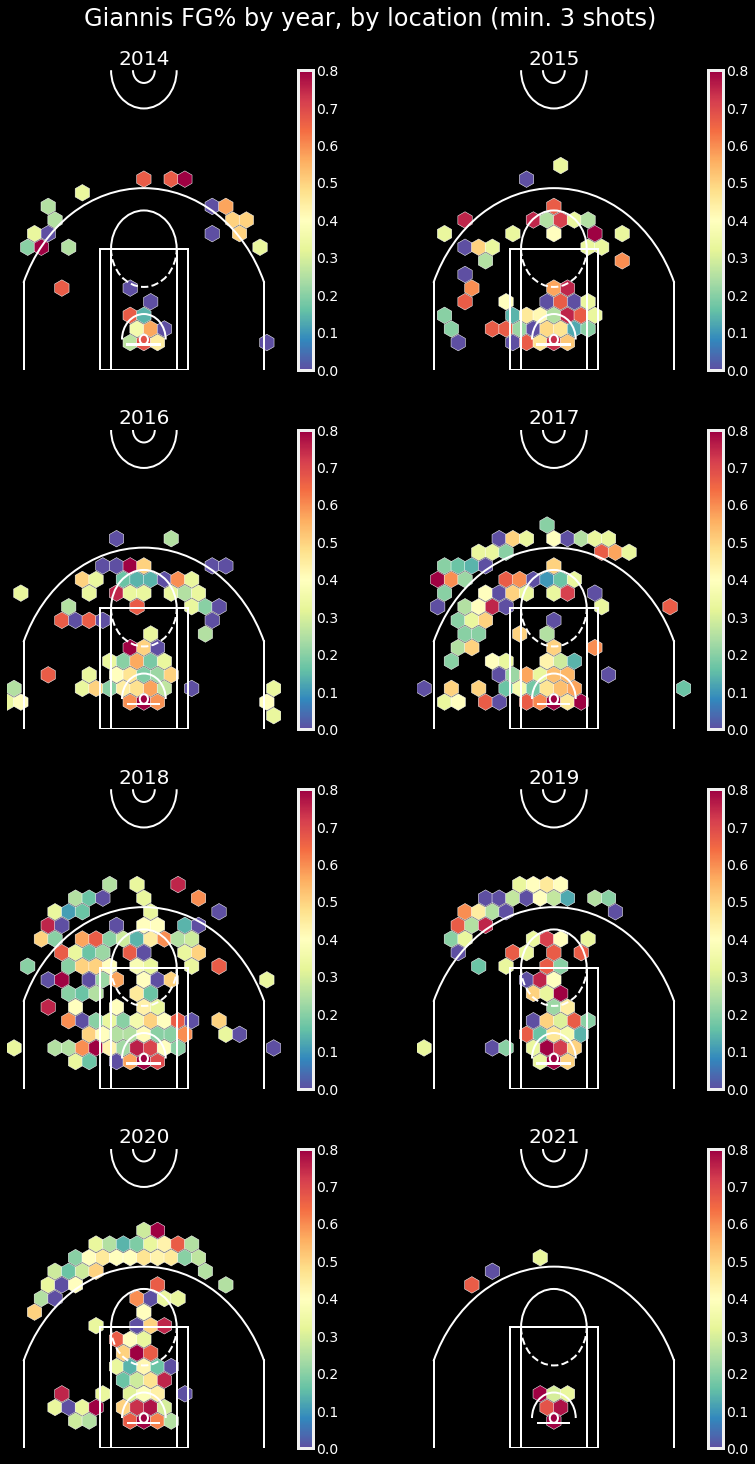

In [22]:
fig = plt.figure(figsize=(12, 22))
fig.patch.set_facecolor('black')
for i in range(1, len(years)+1):
    year = years[i-1]
    plt.subplot(4,2,i)
    plt.xlim(-250, 250)
    plt.ylim(-47.5, 422.5)
    ax = plt.scatter(year_dict[year]['X'], year_dict[year]['Y'],
                c=year_dict[year]['pcts_by_hex'], cmap='Spectral_r',
                marker='h', s = 275, edgecolor='white', vmax=0.8)
    color_bar = plt.colorbar()
    cbytick = plt.getp(color_bar.ax.axes, 'yticklabels')
    plt.setp(cbytick, color='white')
    draw_court(color='white')
    plt.title('20' + year, color='white')
    plt.axis('off')
plt.suptitle('Giannis FG% by year, by location (min. 3 shots)',
             color='white', size=24)
plt.subplots_adjust(top=0.94)
plt.show()

Year, after year, there just aren't many areas of high efficiency away from the basket (where efficiency remarkably seems to keep increasing each year). Even in the paint (outside of teh restricted area around the basket), his efficiency is in shades of green (~30%). It's pretty apparent from these charts why teams who are able to keep him away from the basekt in the playoffs are so effective at slowing him down.

There is another pattern that stands out a bit to me: If you look closely at his 3-point shooting in 2020, he shoots a very respectable 40% or on threes that are straight on and that hug the 3-point line. But when he shoots from a couple feet behind the line (which he does a fair amount), the accuracy drops off significantly.

(Note: 2021 is only 9 games in when I first published this, so there just isn't enough data.)

## Shooting volume and efficiency by quarter

For the remaining visuals, I'm going to use [effective FG%](https://en.wikipedia.org/wiki/Effective_field_goal_percentage) instead of FG%. 

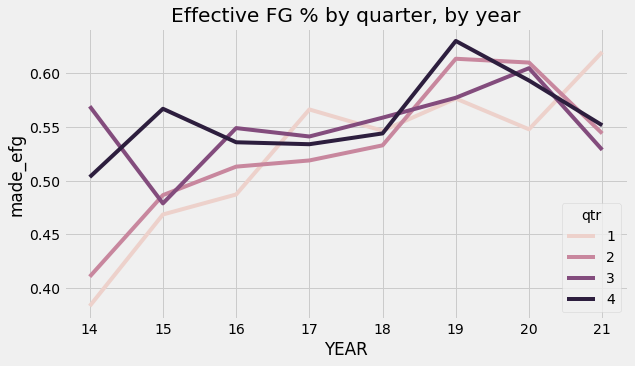

In [31]:
plt.figure(figsize=(9,5))
ax = sns.lineplot(x='YEAR', y='made_efg', hue='qtr',
                  data = shots[shots.qtr<=4], ci=None)
ax.set_title('Effective FG % by quarter, by year')
plt.show()

Aside from the steady increase in efficiency (across nearly all quarters) since his rookie year, not many obvious patterns of note here. Only a few other things stand out:
- High accuracy in 4th quarter during second season (when he had a much smaller role and took far fewer shots).
- Noticeable jump in second half (Q3 and Q4) efficiency in the 2019 season.
- Slow start to current (2021) season.

## By shot type

In [32]:
shot_type_counts = shots.groupby('shot_type')[['made_efg', 'attempted']].sum()\
                .reset_index().sort_values(by='attempted', ascending=False)


In [33]:
shot_type_counts['efg_pct'] = shot_type_counts.made_efg / shot_type_counts.attempted

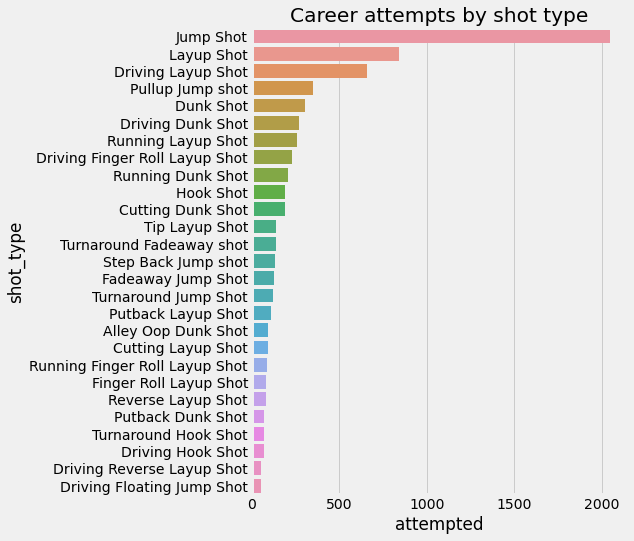

In [35]:
plt.figure(figsize=(6,8))
ax=sns.barplot(x='attempted', y='shot_type',
                 data=shot_type_counts[shot_type_counts.attempted>=50])\
                .set_title('Career attempts by shot type')

The generic "Jump Shot" label is not terribly informative, and I can't find a precise definition of it on the NBA stats site. I assume it would include catch-and-shoots, but not really sure what else. Alas, we're stuck working with it.

Unsurprisingly, we can see that outside of the generic jump shot, Giannis' shots are heavily clustered around the basket. 
  
Looking below, we can see that his jump shooting is inefficient (again, obvious to anyone who's watched a Bucks game).

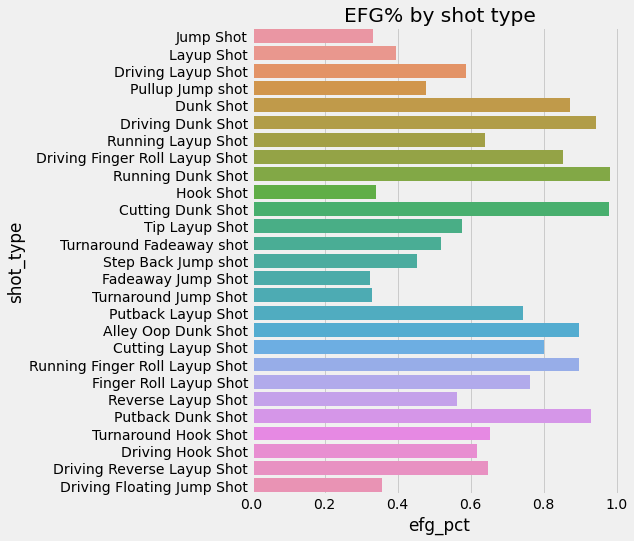

In [36]:
plt.figure(figsize=(6,8))
ax=sns.barplot(x='efg_pct', y='shot_type',
                 data=shot_type_counts[shot_type_counts.attempted>=50])\
                .set_title('EFG% by shot type')

### Has volume an efficiency for certain types of shots changed over the years?

In [37]:
# Since the number of shots taken/games played/minutes played varies each year,
# we can't use raw counts and instead need to normalize the data.
shots_by_year = shots.groupby('YEAR').attempted.sum().reset_index()\
                .rename(columns={'attempted': 'all_types_attempted'})

shot_types_by_year = shots.groupby(['YEAR','shot_type'])[['attempted','made_efg']]\
                    .sum().reset_index()

shot_types_by_year = shot_types_by_year.merge(shots_by_year, how='left',
                                             on='YEAR')

shot_types_by_year['pct_of_shots'] = shot_types_by_year.attempted /\
                                    shot_types_by_year.all_types_attempted

I'm most interested in shot volume among the more common shot types, a few of which (layups, dunks, hook shots) I'll roll into categories.

In [38]:
shot_types_by_year['shot_type_cat'] = np.where(shot_types_by_year.shot_type.str.contains('Layup'), 'Layup',
                                    np.where(shot_types_by_year.shot_type.str.contains('Dunk'), 'Dunk',
                                    np.where(shot_types_by_year.shot_type.str.contains('Hook'), 'Hook Shot',
                                            shot_types_by_year.shot_type)))

shot_cats = ['Layup',
            'Dunk',
            'Hook Shot',
            'Jump Shot',
            'Pullup Jump shot',
            'Turnaround Fadeaway shot',
            'Step Back Jump shot',
            'Fadeaway Jump Shot',
            'Turnaround Jump Shot']

### filter shot types by year to only what we care about
shot_types_filtered = shot_types_by_year[shot_types_by_year.shot_type_cat\
                                        .isin(shot_cats)]

shot_types_made_filtered = shot_types_by_year[shot_types_by_year.shot_type_cat\
                                        .isin(shot_cats)]

### resum columns at category level
shot_types_filtered = shot_types_filtered.groupby(['YEAR', 'shot_type_cat'])\
                    [['attempted', 'all_types_attempted', 'pct_of_shots', 'made_efg']]\
                    .sum().reset_index()
### calculate EFG pct
shot_types_filtered['efg_pct'] = shot_types_filtered.made_efg / shot_types_filtered.attempted

Because he didn't have any shots in a couple of these categories his rookie year, I'm going to drop that first year.

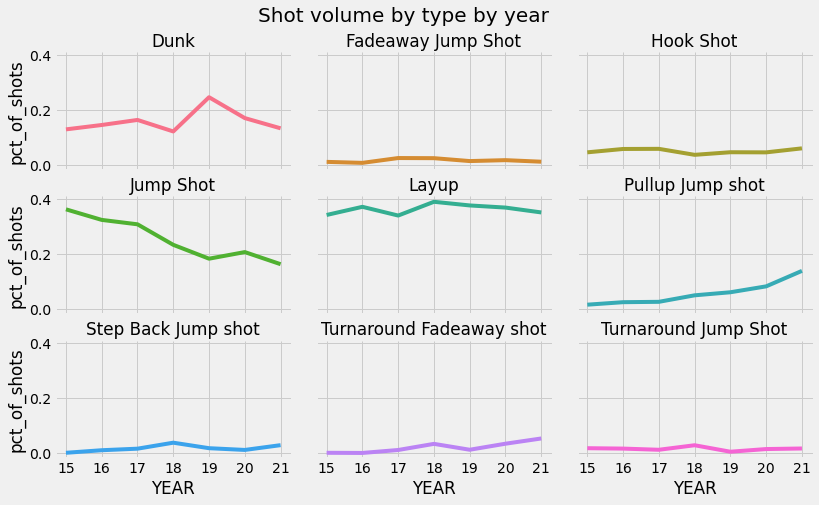

In [39]:
shot_types_filtered = shot_types_filtered[shot_types_filtered.YEAR!='14']

grid = sns.FacetGrid(shot_types_filtered, col='shot_type_cat', hue='shot_type_cat', col_wrap=3)
grid.map(plt.plot, 'YEAR', 'pct_of_shots')
grid.set_titles(row_template='{row_name}', col_template = '{col_name}')
grid.fig.set_size_inches(12,7)
grid.fig.suptitle('Shot volume by type by year', size=20)
grid.fig.subplots_adjust(top=0.89)

A few things that stand out:
- He's shooting more pullup jumpters (which are likley mostly threes).
- Shooting slightly more turnaround fadeaways.
- He's shooting fewer generic "jump shots," which, again, not 100% sure what these are, but I'd bet much of it is catch-and-shoot and mid-range jumpters.
- The volume of his shots in the 2019 season that were dunks (more than 20 percent) is really just crazy for a high-volume scorer.

**Now, what about the efficiency of these shots?**  
  
The 2021 numbers are on a small sample size so far, so I won't really pay much attention to those. It does appear that his "jump shot" and turnround shot efficiency has gradually improved in recent years, though they still aren't great. His fadeaway (non turnaround) and stepback numbers aren't improving (stepbacks really dropped off in '19 before rebounding last year. Ultimately, it's clear that the growth in his scoring numbers over the years is not really influenced at all by any sort of improvement in jump shooting efficiency. 

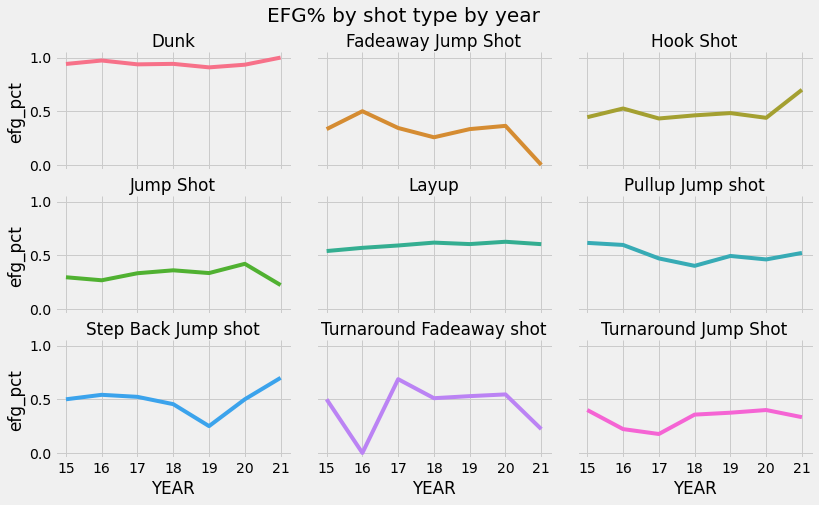

In [40]:
grid = sns.FacetGrid(shot_types_filtered, col='shot_type_cat', hue='shot_type_cat', col_wrap=3)
grid.map(plt.plot, 'YEAR', 'efg_pct')
grid.set_titles(col_template = '{col_name}')
grid.fig.set_size_inches(12,7)
grid.fig.suptitle('EFG% by shot type by year', size=20)
grid.fig.subplots_adjust(top=0.89)

## By zone

In [41]:
by_zone_by_year = shots.groupby(['YEAR', 'zone'])[['made_efg', 'attempted']].sum().reset_index()

by_zone_by_year = by_zone_by_year.merge(shots_by_year, how='left', on='YEAR')

by_zone_by_year['pct_of_shots'] = by_zone_by_year.attempted / by_zone_by_year.all_types_attempted
by_zone_by_year['efg_pct'] = by_zone_by_year.made_efg / by_zone_by_year.attempted

By zone, he's shooting a lot more above the break 3s and a lot fewer mid-range jumbers.

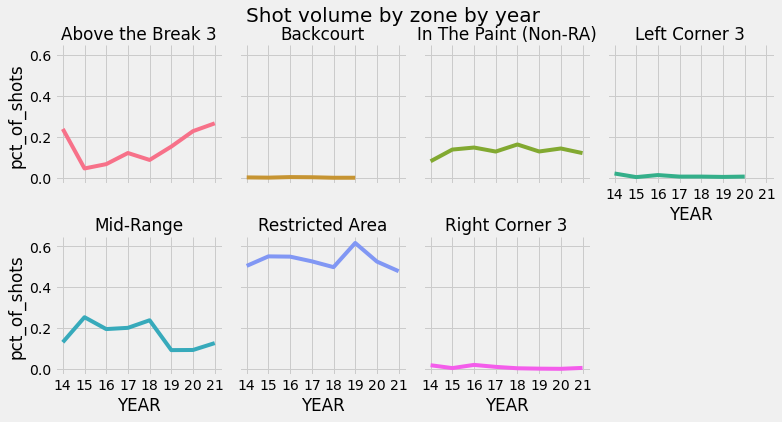

In [42]:
grid = sns.FacetGrid(by_zone_by_year, col='zone', hue='zone', col_wrap=4)
grid.map(plt.plot, 'YEAR', 'pct_of_shots')
grid.set_titles(row_template='{row_name}', col_template = '{col_name}')
grid.fig.set_size_inches(11,6)
grid.fig.suptitle('Shot volume by zone by year', size=20)
grid.fig.subplots_adjust(top=0.89)

In terms of efficiency, his 3-point shooting (I'm disregarding the corners since he shoots so few) stopped improving a few years ago. His efficiency in the restricted area somehow keeps growing each year, which is remarkable considering that he's been near the top of the league in that area for a while now.

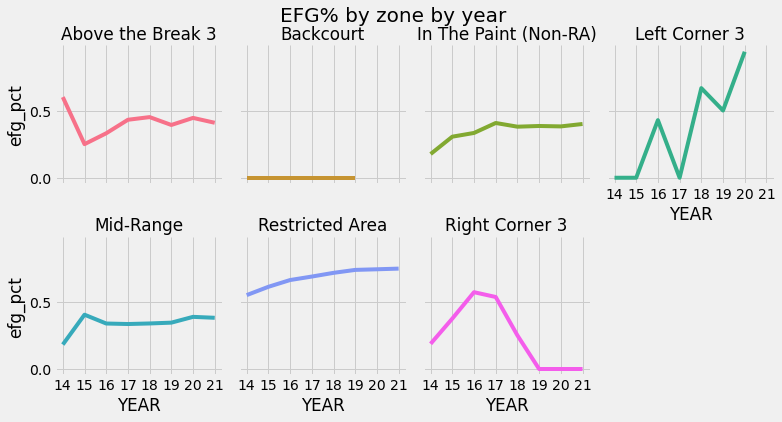

In [43]:
grid = sns.FacetGrid(by_zone_by_year, col='zone', hue='zone', col_wrap=4)
grid.map(plt.plot, 'YEAR', 'efg_pct')
grid.set_titles(row_template='{row_name}', col_template = '{col_name}')
grid.fig.set_size_inches(11,6)
grid.fig.suptitle('EFG% by zone by year', size=20)
grid.fig.subplots_adjust(top=0.89)

## By distance

In [44]:
by_range_by_year = shots.groupby(['YEAR', 'range'])[['made_efg', 'attempted']].sum().reset_index()

by_range_by_year = by_range_by_year.merge(shots_by_year, how='left', on='YEAR')

by_range_by_year['pct_of_shots'] = by_range_by_year.attempted / by_range_by_year.all_types_attempted
by_range_by_year['efg_pct'] = by_range_by_year.made_efg / by_range_by_year.attempted

### filter out back court shots, of which there are only a couple
by_range_by_year = by_range_by_year[by_range_by_year.range!='Back Court Shot']

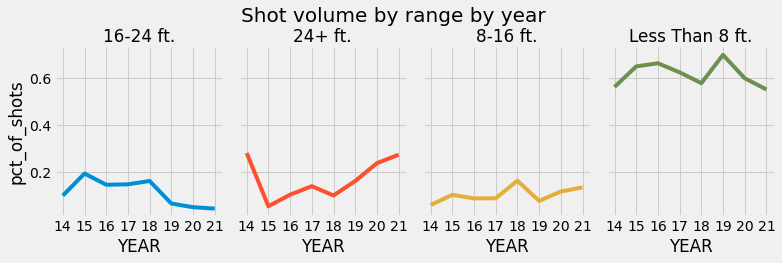

In [45]:
grid = sns.FacetGrid(by_range_by_year, col='range', hue='range', col_wrap=4)
grid.map(plt.plot, 'YEAR', 'pct_of_shots')
grid.set_titles(row_template='{row_name}', col_template = '{col_name}')
grid.fig.set_size_inches(11,4)
grid.fig.suptitle('Shot volume by range by year', size=20)
grid.fig.subplots_adjust(top=0.84)

Not much to comment on in these two plots that wasn't already mentioned.

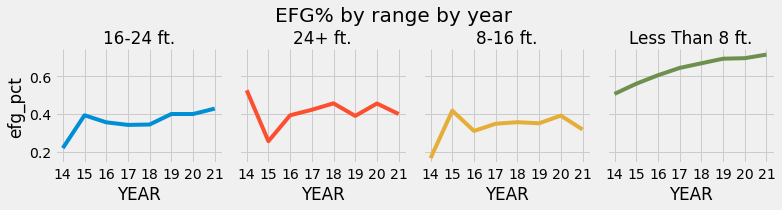

In [46]:
grid = sns.FacetGrid(by_range_by_year, col='range', hue='range', col_wrap=4)
grid.map(plt.plot, 'YEAR', 'efg_pct')
grid.set_titles(row_template='{row_name}', col_template = '{col_name}')
grid.fig.set_size_inches(11,3)
grid.fig.suptitle('EFG% by range by year', size=20)
grid.fig.subplots_adjust(top=0.78)

## By direction

In [47]:
by_dir_by_year = shots.groupby(['YEAR', 'direction'])[['made_efg', 'attempted']].sum().reset_index()

by_dir_by_year = by_dir_by_year.merge(shots_by_year, how='left', on='YEAR')

by_dir_by_year['pct_of_shots'] = by_dir_by_year.attempted / by_dir_by_year.all_types_attempted
by_dir_by_year['efg_pct'] = by_dir_by_year.made_efg / by_dir_by_year.attempted

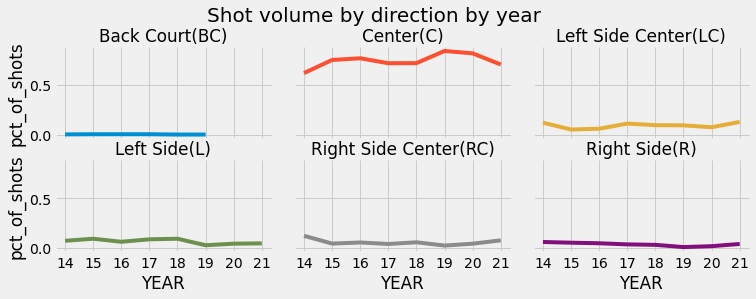

In [48]:
grid = sns.FacetGrid(by_dir_by_year, col='direction', hue='direction', col_wrap=3)
grid.map(plt.plot, 'YEAR', 'pct_of_shots')
grid.set_titles(row_template='{row_name}', col_template = '{col_name}')
grid.fig.set_size_inches(11,4)
grid.fig.suptitle('Shot volume by direction by year', size=20)
grid.fig.subplots_adjust(top=0.84)

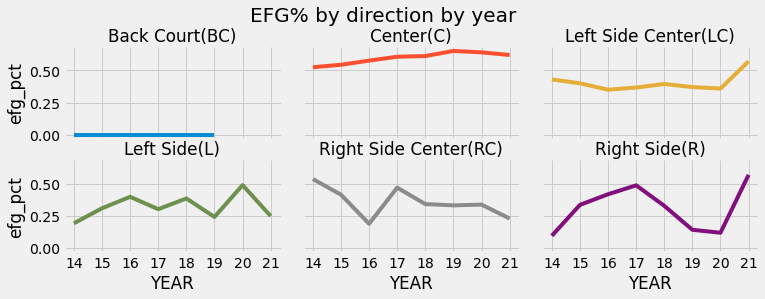

In [49]:
grid = sns.FacetGrid(by_dir_by_year, col='direction', hue='direction', col_wrap=3)
grid.map(plt.plot, 'YEAR', 'efg_pct')
grid.set_titles(row_template='{row_name}', col_template = '{col_name}')
grid.fig.set_size_inches(11,4)
grid.fig.suptitle('EFG% by direction by year', size=20)
grid.fig.subplots_adjust(top=0.84)